# **GistTerms Summmarization using T5 Small Model**

In [4]:
import os
import re
import zipfile
import shutil

In [5]:
# Define the input zip files and output directories
zip_file_1 = "ToSDRData.zip"
zip_file_2 = "ReferenceSummaries.zip"
output_dir_1 = "DataSet"
output_dir_2 = "ReferenceSummaries"

def recreate_folder(folder_path):
    # If the folder exists, delete it
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    # Recreate the folder
    os.makedirs(folder_path)

# Recreate the output folders
recreate_folder(output_dir_1)
recreate_folder(output_dir_2)

# Function to extract files from a zip
def extract_files(zip_file, output_dir, folder_name):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # List all files in the zip
        all_files = zip_ref.namelist()

        # Filter files in the specific folder (e.g., 'text/')
        folder_files = [f for f in all_files if f.startswith(folder_name + '/') and not f.endswith('/')]

        # Extract only the files in the specified folder
        for file in folder_files:
            # Determine the target path in the output folder
            target_path = os.path.join(output_dir, os.path.relpath(file, folder_name))

            # Ensure the directory structure exists
            os.makedirs(os.path.dirname(target_path), exist_ok=True)

            # Extract the file
            with zip_ref.open(file) as source, open(target_path, 'wb') as target:
                target.write(source.read())

# Extract files from 'text' folder in ToSDRData.zip into DataSet
extract_files(zip_file_1, output_dir_1, 'text')

# Extract files from 'text' folder in ReferenceSummaries.zip into ReferenceSummaries
extract_files(zip_file_2, output_dir_2, 'text')

print(f"All files from 'text' folder in {zip_file_1} have been extracted to {output_dir_1}.")
print(f"All files from 'text' folder in {zip_file_2} have been extracted to {output_dir_2}.")

All files from 'text' folder in ToSDRData.zip have been extracted to DataSet.
All files from 'text' folder in ReferenceSummaries.zip have been extracted to ReferenceSummaries.


In [6]:
!pip install spacy
# Load spaCy's English model
!python -m spacy download en_core_web_sm
# Import the spacy module
import spacy # This line is added to import spacy into the current scope

nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [18]:
import os
import shutil
import re
import spacy
from bs4 import BeautifulSoup
import html

# Load spaCy model for sentence segmentation
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")  # Add the sentencizer component

# Input and output folder paths
input_folder = "DataSet"
output_folder = "PreprocessedDataSet"

def recreate_folder(folder_path):
    # If the folder exists, delete it
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    # Recreate the folder
    os.makedirs(folder_path)

# Recreate the output folder
recreate_folder(output_folder)

# Function to remove HTML tags but retain URLs
def remove_html_tags(text):
    # Parse HTML content using BeautifulSoup
    soup = BeautifulSoup(text, "html.parser")

    # Find and preserve URLs
    urls = [a['href'] for a in soup.find_all('a', href=True)]

    # Extract the plain text
    plain_text = soup.get_text(separator=" ")

    # Reinsert URLs into the text
    for url in urls:
        plain_text += f" {url}"

    return plain_text

# Function to preprocess a single file
def preprocess_text(text):
    # Step 1: Remove HTML tags but retain URLs
    text = remove_html_tags(text)

    # Step 2: Remove special characters and normalize white spaces
    text = re.sub(r"[^\x00-\x7F]+", " ", text)  # Remove non-ASCII characters
    text = re.sub(r"\s+", " ", text).strip()  # Normalize spaces and remove leading/trailing spaces

    # Step 3: Remove non-breaking spaces (nbsp) and replace them with regular space
    text = html.unescape(text)  # Convert HTML entities like &nbsp; to actual characters

    # Step 4: Retain enumerations (e.g., 1.1, A, i., etc.)
    enumerations = re.findall(r"(^|\s)(\d+\.\d+|[A-Za-z]|[ivxIVX]+)(?=[\.\)]\s)", text)
    enumerations = {e[1] for e in enumerations}

    # Step 5: Break into sentences for better readability
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]

    # Step 6: Highlight enumerations as important points
    important_points = [sent for sent in sentences if any(e in sent for e in enumerations)]

    # Combine all text and important points
    processed_text = "\n".join(important_points + sentences)
    return processed_text

# Loop through all files in the input folder
for file_name in os.listdir(input_folder):
    input_path = os.path.join(input_folder, file_name)

    # Ensure we process only text files
    if os.path.isfile(input_path) and input_path.endswith(".txt"):
        # Read the file content
        with open(input_path, "r", encoding="utf-8") as file:
            content = file.read()

        # Preprocess the text
        preprocessed_content = preprocess_text(content)

        # Save the preprocessed text to the output folder
        output_path = os.path.join(output_folder, file_name)
        with open(output_path, "w", encoding="utf-8") as file:
            file.write(preprocessed_content)

print(f"Preprocessing completed. Files saved in '{output_folder}'.")

Preprocessing completed. Files saved in 'PreprocessedDataSet'.


In [8]:
!pip install transformers datasets torch
!pip install datasets

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,7.423500,7.658286
2,7.378900,7.658286
3,7.437500,7.649769
4,7.453100,7.631740
5,7.335000,7.631740
6,7.306100,7.624569


Fine-tuned model saved to FineTunedModel


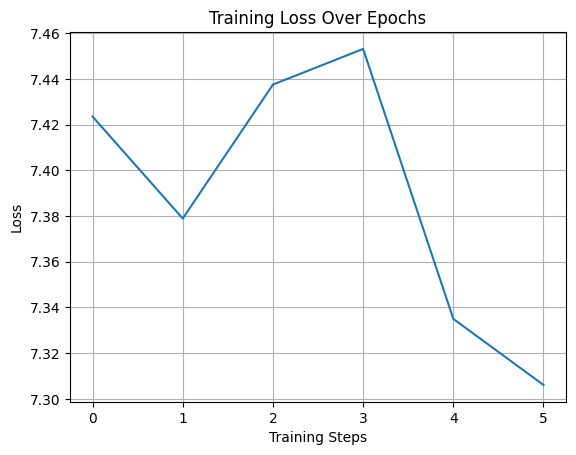

In [20]:
import os
import matplotlib.pyplot as plt
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset
import torch
torch.cuda.empty_cache()

# Define paths to the folders
input_folder = "PreprocessedDataSet"
reference_folder = "ReferenceSummaries"
output_folder = "FineTunedModel"

# Load the T5-small model and tokenizer
model_name = "t5-small"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Function to read the content of files in a folder
def read_files_from_folder(folder_path, num_files=20):
    files = os.listdir(folder_path)
    files = sorted(files)[:num_files]  # Only take first 20 files
    texts = []
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r", encoding="utf-8") as file:
            texts.append(file.read())
    return texts

# Read the preprocessed texts and reference summaries
preprocessed_texts = read_files_from_folder(input_folder)
reference_summaries = read_files_from_folder(reference_folder)

# Prepare the dataset
data = {'input_text': preprocessed_texts, 'summary': reference_summaries}

# Create a Hugging Face Dataset
train_dataset = Dataset.from_dict(data)

# Tokenize the input text and summaries
def tokenize_function(examples):
    all_input_ids = []
    all_labels = []

    for text, summary in zip(examples['input_text'], examples['summary']):
        # Tokenize the input text and summary
        input_ids = tokenizer.encode(text, truncation=True, max_length=512, padding='max_length')
        target_ids = tokenizer.encode(summary, truncation=True, max_length=150, padding='max_length')

        # Append tokenized inputs and labels
        all_input_ids.append(input_ids)
        all_labels.append(target_ids)

    # Return tokenized inputs and labels
    return {
        'input_ids': all_input_ids,
        'labels': all_labels,
    }

# Apply tokenization with map function
train_dataset = train_dataset.map(tokenize_function, batched=True)

# Split the dataset into training and validation (80%/20%)
train_dataset, eval_dataset = train_dataset.train_test_split(test_size=0.2).values()

# Define training arguments with logging enabled
training_args = TrainingArguments(
    output_dir=output_folder,
    evaluation_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=2,  # Adjust batch size based on memory
    per_device_eval_batch_size=2,   # Set evaluation batch size to 2
    num_train_epochs=6,
    weight_decay=0.01,
    save_steps=500,  # Save checkpoints every 500 steps
    save_total_limit=2,  # Keep the last 2 saved models
    fp16=True,  # Enable mixed precision for better memory management
    gradient_accumulation_steps=8,  # Simulate larger batch sizes
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=1,  # Log every 50 steps
)

# Custom callback to store the loss at each step
class LossPlotCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.train_losses.append(logs["loss"])

# Initialize the loss callback
loss_callback = LossPlotCallback()

# Initialize the Trainer with the callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[loss_callback],  # Add the loss callback here
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained(output_folder)
tokenizer.save_pretrained(output_folder)

print(f"Fine-tuned model saved to {output_folder}")

# Plotting the training loss
plt.plot(loss_callback.train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [33]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00


In [4]:
import os
import shutil
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import Dataset
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the fine-tuned model and tokenizer
model_name = "FineTunedModel"  # Path to your saved fine-tuned model
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Move model to GPU if available
model = model.to(device)

# Directory where preprocessed data is stored
input_folder = "PreprocessedDataSet"
generated_folder = "GeneratedSummaries"
reference_folder = "ReferenceSummaries"

# Function to recreate folder (delete and create a new one)
def recreate_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)

# Recreate the generated folder to ensure it's empty
recreate_folder(generated_folder)

def summarize_text(text):
    """Summarize the input text using the fine-tuned model, focusing on privacy, law, data, risks, and related aspects."""

    # Expanded prompt to include more keywords related to privacy, law, data, risks, and policies
    prompt = (
        f"summarize the following text, focusing on privacy, data, security, risks, laws, regulations, "
        "internet policies, user consent, GDPR, terms of service, confidentiality, privacy policy, "
        "user rights, compliance, legal obligations, and dangers related to personal data and internet use: "
        f"{text}"
    )

    # Move the input text to GPU
    inputs = tokenizer.encode(prompt, return_tensors="pt", max_length=4096, truncation=True).to(device)

    # Adjust summarization parameters for better results
    summary_ids = model.generate(
        inputs,
        max_length=500,  # Increase max_length to capture more information
        min_length=100,  # Reduce min_length to allow more detailed text
        length_penalty=1.0,  # Lower penalty to prevent truncation
        num_beams=6,  # Increase beams for better quality
        early_stopping=True
    )

    # Decode summary and move back to CPU if needed
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def generate_scores(predictions, references):
    """Compute ROUGE scores for the predicted summaries against the reference summaries."""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    results = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    # Calculate ROUGE scores for each summary
    for prediction, reference in zip(predictions, references):
        scores = scorer.score(reference, prediction)
        results['rouge1'].append(scores['rouge1'].fmeasure)
        results['rouge2'].append(scores['rouge2'].fmeasure)
        results['rougeL'].append(scores['rougeL'].fmeasure)

    # Calculate average ROUGE scores
    avg_scores = {key: sum(value) / len(value) for key, value in results.items()}
    return avg_scores

def calculate_bleu_score(predictions, references):
    """Compute BLEU scores for the predicted summaries against the reference summaries."""
    bleu_scores = []
    smoothing_function = SmoothingFunction().method4

    # Calculate BLEU score for each summary
    for prediction, reference in zip(predictions, references):
        # Tokenize the prediction and reference
        prediction_tokens = prediction.split()
        reference_tokens = [ref.split() for ref in reference.split('\n')]  # List of references (for BLEU, we use a list of references)

        bleu_score = sentence_bleu(reference_tokens, prediction_tokens, smoothing_function=smoothing_function)
        bleu_scores.append(bleu_score)

    # Calculate average BLEU score
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    return avg_bleu_score

# Loop through preprocessed documents, summarize them, and save the results
all_summaries = []
all_references = []  # For storing the reference summaries

for file_name in os.listdir(input_folder):
    input_path = os.path.join(input_folder, file_name)

    # Process only text files
    if os.path.isfile(input_path) and input_path.endswith(".txt"):
        # Read the preprocessed file content
        with open(input_path, "r", encoding="utf-8") as file:
            content = file.read()

        # Generate the summary for the document
        summary = summarize_text(content)

        # Split the summary into individual sentences or lines
        summary_lines = summary.split('. ')  # Split by period followed by space for sentences

        # Save the summary to the generated folder, with each sentence on a new line
        generated_path = os.path.join(generated_folder, file_name)
        with open(generated_path, "w", encoding="utf-8") as file:
            for line in summary_lines:
                file.write(line.strip() + "\n")  # Write each sentence on a new line

        # Collect the generated summary
        all_summaries.append(summary)

        # Read the reference summary if it exists
        reference_path = os.path.join(reference_folder, file_name)
        if os.path.exists(reference_path):
            with open(reference_path, "r", encoding="utf-8") as ref_file:
                reference_summary = ref_file.read()
            all_references.append(reference_summary)

# If references exist, calculate ROUGE scores
if all_references:
    scores = generate_scores(all_summaries, all_references)
    print("ROUGE Scores:", scores)

    # Calculate BLEU score
    bleu_score = calculate_bleu_score(all_summaries, all_references)
    print(f"BLEU Score: {bleu_score:.4f}")
else:
    print("No reference summaries found for evaluation.")

print(f"Summarization completed. Summaries saved in '{generated_folder}'.")


Using device: cuda
ROUGE Scores: {'rouge1': 0.18911262207006604, 'rouge2': 0.051521962739474805, 'rougeL': 0.11170369323142637}
BLEU Score: 0.0654
Summarization completed. Summaries saved in 'GeneratedSummaries'.
